In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np


AUTOTUNE = tf.data.AUTOTUNE

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8utq0vg5
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-8utq0vg5
  Created wheel for tensorflow-examples: filename=tensorflow_examples-c22d9154cf82481b72ba618dc02eb3cbca06fbda_-cp37-none-any.whl size=260223 sha256=f64502e876122f94de86189fcb925caf600f9c12a25e028f030e880a20192420
  Stored in directory: /tmp/pip-ephem-wheel-cache-u3zclznh/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import cv2

In [ ]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteB505HF/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteB505HF/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteB505HF/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteB505HF/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
#train_normal.map(lambda x,y:print(type(x)))

In [ ]:
train_vangogh, train_normal = dataset['trainA'], dataset['trainB']
test_normal, test_vangogh = dataset['testA'], dataset['testB']

In [ ]:

train_vangogh, train_normal = dataset['trainA'], dataset['trainB']
test_normal, test_vangogh = dataset['testA'], dataset['testB']

train_vangogh = train_vangogh.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_normal = train_normal.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_vangogh = test_vangogh.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_normal = test_normal.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
#Dataset to Dataframe
#train_horses_dataset = tfds.as_dataframe(test_zebras)
#for i in range(0,100):
  #train_horses_numpy = train_horses_dataset.loc[i].to_numpy()
  #train_horses_numpy[0][0].shape
  #imgplot = plt.imshow(train_horses_numpy[0][0])
  #plt.show()


In [ ]:
sample_vangogh = next(iter(train_vangogh))
sample_normal = next(iter(train_normal))

In [ ]:
#IMPORTING OF OUR TEST DATA

img = cv2.imread("./deneme.jfif")
img = img[:,:,::-1]
imgresize = cv2.resize(img, (256,256))
imgresize = np.array([imgresize.tolist()])
img_tf = tf.convert_to_tensor(
    imgresize, dtype=None, dtype_hint=None, name=None
)
processed_img = preprocess_image_test(img_tf,img_tf)

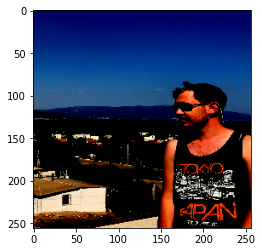

In [ ]:
plt.imshow(processed_img.numpy()[0])

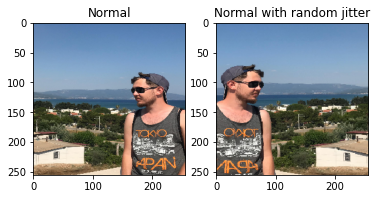

In [ ]:
plt.subplot(121)
plt.title('Normal')
plt.imshow(processed_img[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Normal with random jitter')
plt.imshow(random_jitter(processed_img[0]) * 0.5 + 0.5)

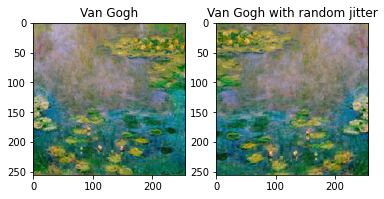

In [ ]:
plt.subplot(121)
plt.title('Van Gogh')
plt.imshow(sample_vangogh[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Van Gogh with random jitter')
plt.imshow(random_jitter(sample_vangogh[0]) * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

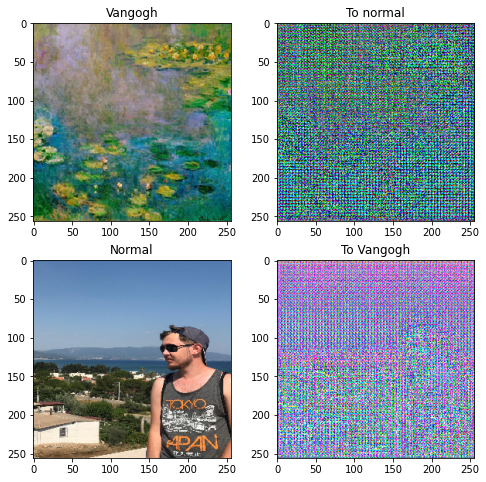

In [ ]:
to_vangogh = generator_g(processed_img)
to_normal = generator_f(sample_vangogh)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_vangogh, to_normal, processed_img, to_vangogh]
title = ['Vangogh', 'To normal', 'Normal', 'To Vangogh']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

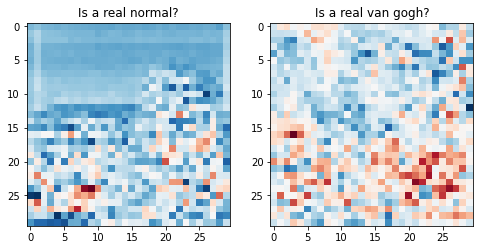

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real normal?')
plt.imshow(discriminator_y(processed_img)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real van gogh?')
plt.imshow(discriminator_x(sample_vangogh)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 50

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    print("Total: ", total_cycle_loss)

    # Total generator loss = adversarial loss + cycle loss
    id_loss_y = identity_loss(real_y, same_y)
    id_loss_x = identity_loss(real_x, same_x)
    total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_y
    total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_x

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return (total_cycle_loss, gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, id_loss_x, id_loss_y)

In [ ]:
cycle_loss_list = []
gen_g_loss_list = []
gen_f_loss_list = []
disc_x_loss_list = []
disc_y_loss_list = []
id_loss_x_list = []
id_loss_y_list = []

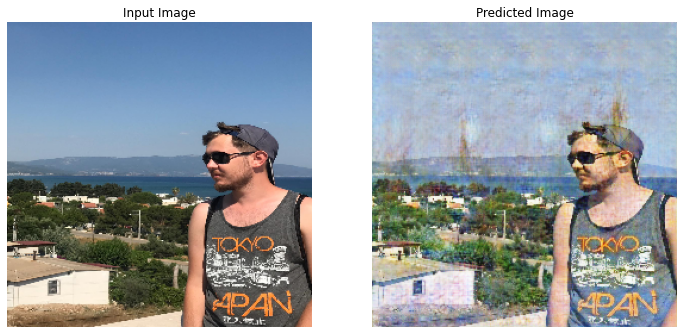

Time taken for epoch 36 is 855.1676509380341 sec

..................................................................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  total_cycle_loss = 0
  total_gen_g_loss_loss = 0
  total_gen_f_loss_loss = 0
  total_disc_x_loss_loss = 0
  total_disc_y_loss_loss = 0
  total_id_loss_x_loss = 0
  total_id_loss_y_loss = 0
  length=0
  for image_x, image_y in tf.data.Dataset.zip((train_vangogh, train_normal)):
    cycle_loss, gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, id_loss_x, id_loss_y = train_step(image_y, image_x)
    total_cycle_loss += cycle_loss
    total_gen_g_loss_loss += gen_g_loss
    total_gen_f_loss_loss += gen_f_loss
    total_disc_x_loss_loss += disc_x_loss
    total_disc_y_loss_loss += disc_y_loss
    total_id_loss_x_loss += id_loss_x
    total_id_loss_y_loss += id_loss_y
    length+=1
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  cycle_loss_list.append(total_cycle_loss/length)
  gen_g_loss_list.append(total_gen_g_loss_loss/length)
  gen_f_loss_list.append(total_gen_f_loss_loss/length)
  disc_x_loss_list.append(total_disc_x_loss_loss/length)
  disc_y_loss_list.append(total_disc_y_loss_loss/length)
  id_loss_x_list.append(total_id_loss_x_loss/length)
  id_loss_y_list.append(total_id_loss_y_loss/length)

  clear_output(wait=True)
  # Using a consistent image (sample_normal) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, processed_img)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
import pandas as pd
import numpy as np

df_loss = pd.DataFrame(columns=["cycle_loss","gen_g_loss","gen_f_loss","disc_x_loss","disc_y_loss","id_loss_x","id_loss_y"])
df_loss["cycle_loss"] = pd.Series(np.array(cycle_loss_list))
df_loss["gen_g_loss"] = pd.Series(np.array(gen_g_loss_list))
df_loss["gen_f_loss"] = pd.Series(np.array(gen_f_loss_list))
df_loss["disc_x_loss"] = pd.Series(np.array(disc_x_loss_list))
df_loss["disc_y_loss"] = pd.Series(np.array(disc_y_loss_list))
df_loss["id_loss_x"] = pd.Series(np.array(id_loss_x_list))
df_loss["id_loss_y"] = pd.Series(np.array(id_loss_y_list))

NameError: ignored

In [ ]:
df_loss

In [ ]:
'''
epoch_list=[i for i in range(1,EPOCHS+1)]
plt.title('Loss in each epochs with learning rate = '+str(0.001))
plt.plot(epoch_list, cycle_loss_list)
'''

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
epoch_list=[i for i in range(1,EPOCHS+1)]
figure(figsize=(35, 15), dpi=80)
plt.title('Loss changes over epochs')
#epoch_list = [i for i in range(120)]
plt.xlabel("Epoch")
plt.ylabel("Loss") 

plt.plot(epoch_list, cycle_loss_list, 'g', label='cycle_loss')
plt.plot(epoch_list, gen_g_loss_list, 'b', label='gen_g_loss')
plt.plot(epoch_list, gen_f_loss_list, 'r', label='gen_f_loss')
plt.plot(epoch_list, disc_x_loss_list, 'y', label='disc_x_loss')
plt.plot(epoch_list, disc_y_loss_list, 'purple', label='disc_y_loss')
plt.plot(epoch_list, id_loss_x_list, 'gray', label='id_loss_x')
plt.plot(epoch_list, id_loss_y_list, 'brown', label='id_loss_y')
plt.legend()
plt.show()

In [ ]:
# Run the trained model on the test dataset
for inp in test_vangogh.take(5):
  generate_images(generator_g, inp)

In [ ]:
generate_images(generator_g, processed_img) 

In [ ]:
generate_images(generator_g, processed_img) 